# Training the Transformers with 2023 data

Following the "main.py" script in tranad/

In [21]:
import os
import sys
import json
from time import time
from pprint import pprint

sys.path.append('/eos/user/j/jhoya/DAQ/AnomalyDetection/strada/transformer_based_detection/tranad/')

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tqdm import tqdm
#from src.models import *
# from src.constants import *
# from src.plotting import *
# from src.pot import *
#from src.utils import *
# from src.diagnosis import *
# from src.merlin import *
from src.dataset_loader_hlt_datasets import HLTDataset
from torch.utils.data import Dataset, DataLoader, TensorDataset
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pickle
from torch.utils.tensorboard import SummaryWriter
from sklearn.preprocessing import MinMaxScaler

#from torch_profiling_utils.torchinfowriter import TorchinfoWriter
#from torch_profiling_utils.fvcorewriter import FVCoreWriter



In [22]:
class color:
    HEADER = '\033[95m'
    BLUE = '\033[94m'
    GREEN = '\033[92m'
    RED = '\033[93m'
    FAIL = '\033[91m'
    ENDC = '\033[0m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'

In [23]:
def load_dataset(dataset):

    loader = []

    if 'HLT' in dataset:

        data_source = dataset.split('_')[0]
        variant = int(dataset.split('_')[-1])
        print(data_source)
        print(variant)

        train_set = HLTDataset(data_source, variant,
                                        'train', False,
                                        'minmax', 'train_set_fit',
                                        applied_augmentations=\
                                                args.augmentations,
                                        augmented_dataset_size_relative=\
                                                args.augmented_dataset_size_relative,
                                        augmented_data_ratio=\
                                                args.augmented_data_ratio)

        folder = f'./checkpoints/{args.model}_{args.dataset}_{augmentation_string}_seed_{int(args.seed)}/'

        os.makedirs(folder, exist_ok=True)
        train_set.pickle_scaler(f'{folder}/scaler.pkl')

        loader.append(train_set.get_data())

        test_set = HLTDataset(data_source, variant,
                                        'test', False,
                                        'minmax', 'train_set_fit',
                                        applied_augmentations=\
                                                args.augmentations,
                                        augmented_dataset_size_relative=\
                                                args.augmented_dataset_size_relative,
                                        augmented_data_ratio=\
                                                args.augmented_data_ratio)

        loader.append(test_set.get_data())
        loader.append(test_set.get_labels())
        
    #if args.less:
    #    loader[0] = cut_array(0.2, loader[0])


    print(f'Train shape: {loader[0].shape}')
    print(f'Test shape: {loader[1].shape}')

    train_loader = DataLoader(loader[0], batch_size=loader[0].shape[0])
    test_loader = DataLoader(loader[1], batch_size=loader[1].shape[0])
    labels = loader[2]

    return train_loader, test_loader, labels

In [24]:
def load_dataset_indiv(dataset):

    loader = []

    if 'HLT' in dataset:

        data_source = dataset.split('_')[0]
        #data_source = "hlt_448519"
        variant = int(dataset.split('_')[-1])
        print(data_source)
        print(variant)

        train_set = HLTDataset(data_source, variant,
                                        'train', False,
                                        'minmax', 'train_set_fit',
                                        applied_augmentations=\
                                                args.augmentations,
                                        augmented_dataset_size_relative=\
                                                args.augmented_dataset_size_relative,
                                        augmented_data_ratio=\
                                                args.augmented_data_ratio)

        folder = f'./checkpoints/{args.model}_{args.dataset}_{augmentation_string}_seed_{int(args.seed)}/'

        os.makedirs(folder, exist_ok=True)
        train_set.pickle_scaler(f'{folder}/scaler.pkl')

        loader.append(train_set.get_data())

        test_set = HLTDataset(data_source, variant,
                                        'test', False,
                                        'minmax', 'train_set_fit',
                                        applied_augmentations=\
                                                args.augmentations,
                                        augmented_dataset_size_relative=\
                                                args.augmented_dataset_size_relative,
                                        augmented_data_ratio=\
                                                args.augmented_data_ratio)

        loader.append(test_set.get_data())
        loader.append(test_set.get_labels())
        
    #if args.less:
    #    loader[0] = cut_array(0.2, loader[0])


    print(f'Train shape: {loader[0].shape}')
    print(f'Test shape: {loader[1].shape}')

    train_loader = DataLoader(loader[0], batch_size=loader[0].shape[0])
    test_loader = DataLoader(loader[1], batch_size=loader[1].shape[0])
    labels = loader[2]

    return train_loader, test_loader, labels

In [25]:
def save_model(model, optimizer, scheduler, epoch, accuracy_list):
    folder = f'checkpoints/{args.model}_{args.dataset}_{augmentation_string}_seed_{int(args.seed)}/'

    os.makedirs(folder, exist_ok=True)
    file_path = f'{folder}/model.ckpt'
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
        'accuracy_list': accuracy_list}, file_path)


In [26]:
## DAGMM Model (ICLR 18)
class DAGMM(nn.Module):
    def __init__(self, feats):
        super(DAGMM, self).__init__()
        self.name = 'DAGMM'
        self.lr = 0.0001
        self.beta = 0.01
        self.n_feats = feats
        self.n_hidden = 16
        self.n_latent = 8
        self.n_window = 5 # DAGMM w_size = 5
        self.n = self.n_feats * self.n_window
        self.n_gmm = self.n_feats * self.n_window
        self.encoder = nn.Sequential(
            nn.Linear(self.n, self.n_hidden), nn.Tanh(),
            nn.Linear(self.n_hidden, self.n_hidden), nn.Tanh(),
            nn.Linear(self.n_hidden, self.n_latent)
        )
        self.decoder = nn.Sequential(
            nn.Linear(self.n_latent, self.n_hidden), nn.Tanh(),
            nn.Linear(self.n_hidden, self.n_hidden), nn.Tanh(),
            nn.Linear(self.n_hidden, self.n), nn.Sigmoid(),
        )
        self.estimate = nn.Sequential(
            nn.Linear(self.n_latent+2, self.n_hidden), nn.Tanh(), nn.Dropout(0.5),
            nn.Linear(self.n_hidden, self.n_gmm), nn.Softmax(dim=1),
        )

    def compute_reconstruction(self, x, x_hat):
        relative_euclidean_distance = (x-x_hat).norm(2, dim=1) / x.norm(2, dim=1)
        cosine_similarity = F.cosine_similarity(x, x_hat, dim=1)
        #return relative_euclidean_distance, cosine_similarity
        return relative_euclidean_distance.unsqueeze(-1), cosine_similarity.unsqueeze(-1)


    def forward(self, x):
        # x: batch_size x input_dim
        ## Encode Decoder
        #x = x.view(1, -1)
        z_c = self.encoder(x)
        x_hat = self.decoder(z_c)
        ## Compute Reconstructoin
        rec_1, rec_2 = self.compute_reconstruction(x, x_hat)
        z = torch.cat([z_c, rec_1, rec_2], dim=1)
        #z = torch.cat([z_c, rec_1.unsqueeze(-1), rec_2.unsqueeze(-1)], dim=1)
        ## Estimate
        gamma = self.estimate(z)
        #return z_c, x_hat.view(-1), z, gamma.view(-1)
        return z_c, x_hat, z, gamma

In [27]:
def convert_to_windows(data, model):
    windows = []; w_size = model.n_window
    for i, g in enumerate(data): 
        if i >= w_size: w = data[i-w_size:i]
        else: w = torch.cat([data[0].repeat(w_size-i, 1), data[0:i]])
        windows.append(w if 'TranAD' in args.model or 'Attention' in args.model else w.view(-1))
    return torch.stack(windows)

def load_model(modelname, dims):
    #import src.models
    #model_class = getattr(src.models, modelname)
    #model_class = getattr(DAGMM, modelname)
    #model_class = DAGMM()
    model_class = globals().get(modelname)
    model = model_class(dims).double()
    optimizer = torch.optim.AdamW(model.parameters() , lr=model.lr, weight_decay=1e-5)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 5, 0.9)
    fname = f'checkpoints/{args.model}_{args.dataset}_{augmentation_string}_seed_{int(args.seed)}/model.ckpt'

    if os.path.exists(fname) and (not args.retrain or args.test):

        print(f"{color.GREEN}Loading pre-trained model: {model.name}{color.ENDC}")
        checkpoint = torch.load(fname)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        epoch = checkpoint['epoch']
        accuracy_list = checkpoint['accuracy_list']

    else:
        print(f"{color.GREEN}Creating new model: {model.name}{color.ENDC}")
        epoch = -1; accuracy_list = []
    return model, optimizer, scheduler, epoch, accuracy_list


In [28]:
import argparse

args_dict = {
    "use_gpu": False,
    "use_multi_gpu": False,
    "seed":42, 
    "dataset": "HLT_2023",
    #"dataset": "HLT_DCM_2023",
    "checkpoints": "./checkpoints",
    "loss": "MSE",
    "learning_rate": 0.00009727998365755187,
    "num_workers": 8, # Before was 0
    "train_epochs": 10,
    "batch_size": 256, # Before was 128
    "patience": 3,
    "model": "DAGMM",
    "retrain": True,
    #"retrain": False,
    "test": False,
    #"test": True,
    #"apply_augmentations": True,
    "apply_augmentations": False,
    #"augmentations": ['Scale:0.8,1.0', 'Scale_APP:0.8,1.0,0.01,0.05,0.05'],
    #"augmentations": ['Scale:1.0,1.2', 'Scale_APP:1.0,1.2,0.01,0.01,0.01'], 
    "augmentations": [],
    "augmented_dataset_size_relative": 1.0,
    #"augmented_data_ratio": 0.25
    "augmented_data_ratio": 0
}

# Convert the dictionary to an argparse.Namespace object
args = argparse.Namespace(**args_dict)

In [29]:
torch.manual_seed(args.seed)



# We're doing no augmentations for the moment!
augmentations = []

if args.apply_augmentations:

    augmentation_string = ''

    for augmentation in args.augmentations:
        augmentation = augmentation.replace(' ', '')
        aug_type, factors = augmentation.split(':')

        factors = factors.split(',')

        factors_string = '_'.join(factors)

        factors = [float(factor) for factor in factors]

        if len(augmentation_string):
            augmentation_string += '_'

        augmentation_string += aug_type + '_' +\
                                    factors_string

        augmentations.append((aug_type, factors))

    augmentation_string += f'_rel_size_{args.augmented_dataset_size_relative}'\
                                        f'_ratio_{args.augmented_data_ratio:.2f}'


if args.augmented_data_ratio == 0:
    augmentation_string = 'no_augment'

args.augmentations = augmentations

print(augmentation_string)
print(augmentations)

no_augment
[]


In [30]:
device = "cpu"

train_loader, test_loader, labels = load_dataset(args.dataset)
#train_loader, test_loader, labels = load_dataset_indiv(args.dataset)
model, optimizer, scheduler, epoch, accuracy_list = load_model(args.model, labels.shape[1])

model.to(device)

## Prepare data

trainD, testD = next(iter(train_loader)), next(iter(test_loader))
trainO, testO = trainD, testD
if model.name in ['Attention', 'DAGMM', 'USAD', 'MSCRED', 'CAE_M', 'GDN', 'MTAD_GAT', 'MAD_GAN'] or 'TranAD' in model.name: 
    trainD, testD = convert_to_windows(trainD, model), convert_to_windows(testD, model)

model.to(device)

HLT
2023
Train shape: (35468, 146)
Test shape: (45439, 146)
Creating new model: DAGMM


DAGMM(
  (encoder): Sequential(
    (0): Linear(in_features=730, out_features=16, bias=True)
    (1): Tanh()
    (2): Linear(in_features=16, out_features=16, bias=True)
    (3): Tanh()
    (4): Linear(in_features=16, out_features=8, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=8, out_features=16, bias=True)
    (1): Tanh()
    (2): Linear(in_features=16, out_features=16, bias=True)
    (3): Tanh()
    (4): Linear(in_features=16, out_features=730, bias=True)
    (5): Sigmoid()
  )
  (estimate): Sequential(
    (0): Linear(in_features=10, out_features=16, bias=True)
    (1): Tanh()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=16, out_features=730, bias=True)
    (4): Softmax(dim=1)
  )
)

In [43]:
def backprop(epoch,
                model,
                #data,
                #dataO,
                data_loader,
                optimizer,
                scheduler,
                training=True,
                summary_writer=None,
                dataset_name=None):

    l = nn.MSELoss(reduction = 'mean' if training else 'none')
    #feats = dataO.shape[1]

    data_train_list = []
    preds_train_list = []
    data_test_list = []
    preds_test_list = []


    if 'DAGMM' in model.name:
        l = nn.MSELoss(reduction = 'none')
        # In the original code they're not using this. Very computational expensive
        #compute = ComputeLoss(model, 0.1, 0.005, device, model.n_gmm)
        n = epoch + 1; w_size = model.n_window
        l1s = []; l2s = []
        
        # Let's try a different approach
        lambda_energy = 0.1  # Regularization coefficient for sample energy
        eps = 1e-12  # Small constant for numerical stability

        #data = data.to(device)

        if training:
            model.train()
            total_loss = 0
            total_samples = 0
            #for d in data:
            for batch in data_loader:    
                #d = d.to(device)
                d = batch[0].to(device)
                print(d.shape)
                z_c, x_hat, z, gamma = model(d)
                # Compute reconstruction loss
                recon_loss = l(x_hat, d)
                # Compute simplified sample energy using Mahalanobis distance
                mu_z = torch.mean(z, dim=0)
                var_z = torch.var(z, dim=0) + eps  # Ensure variance is non-zero
                delta = z - mu_z
                mahalanobis = torch.sum((delta ** 2) / var_z, dim=1)
                sample_energy = torch.mean(mahalanobis)
                # Total loss
                loss = recon_loss + lambda_energy * sample_energy
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                total_loss += loss.item()
                total_samples += d.size(0)
            avg_loss = total_loss / total_samples
            scheduler.step()
            print(f'Epoch {epoch}, Loss = {avg_loss}')
            return avg_loss, optimizer.param_groups[0]['lr']
        else:
            model.eval()
            with torch.no_grad():
                total_loss = 0
                total_samples = 0
                #for d in data:
                    #d = d.to(device)
                for batch in data_loader:
                    d = batch[0].to(device)
                    z_c, x_hat, z, gamma = model(d)
                    recon_loss = l(x_hat, d)
                    # Compute simplified sample energy
                    mu_z = torch.mean(z, dim=0)
                    var_z = torch.var(z, dim=0) + eps
                    delta = z - mu_z
                    mahalanobis = torch.sum((delta ** 2) / var_z, dim=1)
                    sample_energy = torch.mean(mahalanobis)
                    # Total loss
                    loss = recon_loss + lambda_energy * sample_energy
                    total_loss += loss.item() * d.size(0)
                    total_samples += d.size(0)
                avg_loss = total_loss / total_samples
            return avg_loss
        
        
# Original version
#         if training:
#             for d in data:
#                 d = d.to(device)
#                 _, x_hat, z, gamma = model(d)
#                 l1, l2 = l(x_hat, d), l(gamma, d)
#                 l1s.append(torch.mean(l1).item()); l2s.append(torch.mean(l2).item())
#                 loss = torch.mean(l1) + torch.mean(l2)
#                 optimizer.zero_grad()
#                 loss.backward()
#                 optimizer.step()
#             #print(l1s, l2s)
#             scheduler.step()
#             tqdm.write(f'Epoch {epoch},\tL1 = {np.mean(l1s)},\tL2 = {np.mean(l2s)}')
#             return np.mean(l1s)+np.mean(l2s), optimizer.param_groups[0]['lr']
#         else:
#             ae1s = []

#             for d in data:
#                 # d = d.to(device)
#                 _, x_hat, _, _ = model(d)
#                 ae1s.append(x_hat)
#             ae1s = torch.stack(ae1s)
#             y_pred = ae1s[:, data.shape[1]-feats:data.shape[1]].view(-1, feats)
#             loss = l(ae1s, data)[:, data.shape[1]-feats:data.shape[1]].view(-1, feats)
#             return loss.detach().cpu().numpy(), y_pred.detach().cpu().numpy()

In [44]:
def _save_numpy_array(array: np.array, filename: str):
    
    # Create all necessary directories in the path if they don't exist
    directory = os.path.dirname(filename)
    if not os.path.exists(directory):
        os.makedirs(directory)
    
    with open(filename, 'wb') as output_file:
        np.save(output_file, array)

In [45]:
def plot_accuracies(accuracy_list, folder):
    os.makedirs(f'plots/{folder}/', exist_ok=True)
    trainAcc = [i[0] for i in accuracy_list]
    lrs = [i[1] for i in accuracy_list]
    plt.xlabel('Epochs')
    plt.ylabel('Average Training Loss')
    plt.plot(range(len(trainAcc)), trainAcc, label='Average Training Loss', linewidth=1, linestyle='-', marker='.')
    plt.twinx()
    plt.plot(range(len(lrs)), lrs, label='Learning Rate', color='r', linewidth=1, linestyle='--', marker='.')
    plt.savefig(f'plots/{folder}/training-graph.pdf')
    plt.clf()

In [46]:
class ComputeLoss:
    def __init__(self, model, lambda_energy, lambda_cov, device, n_gmm):
        self.model = model
        self.lambda_energy = lambda_energy
        self.lambda_cov = lambda_cov
        self.device = device
        self.n_gmm = n_gmm
    
    def forward(self, x, x_hat, z, gamma):
        """Computing the loss function for DAGMM."""
        reconst_loss = torch.mean((x-x_hat).pow(2))

        sample_energy, cov_diag = self.compute_energy(z, gamma)

        loss = reconst_loss + self.lambda_energy * sample_energy + self.lambda_cov * cov_diag
        return Variable(loss, requires_grad=True)
    
    def compute_energy(self, z, gamma, phi=None, mu=None, cov=None, sample_mean=True):
        """Computing the sample energy function"""
        if (phi is None) or (mu is None) or (cov is None):
            phi, mu, cov = self.compute_params(z, gamma)

        z_mu = (z.unsqueeze(1)- mu.unsqueeze(0))

        eps = 1e-12
        cov_inverse = []
        det_cov = []
        cov_diag = 0
        for k in range(self.n_gmm):
            cov_k = cov[k] + (torch.eye(cov[k].size(-1))*eps).to(self.device)
            cov_inverse.append(torch.inverse(cov_k).unsqueeze(0))
            det_cov.append((Cholesky.apply(cov_k.cpu() * (2*np.pi)).diag().prod()).unsqueeze(0))
            cov_diag += torch.sum(1 / cov_k.diag())
        
        cov_inverse = torch.cat(cov_inverse, dim=0)
        det_cov = torch.cat(det_cov).to(self.device)

        E_z = -0.5 * torch.sum(torch.sum(z_mu.unsqueeze(-1) * cov_inverse.unsqueeze(0), dim=-2) * z_mu, dim=-1)
        E_z = torch.exp(E_z)
        E_z = -torch.log(torch.sum(phi.unsqueeze(0)*E_z / (torch.sqrt(det_cov)).unsqueeze(0), dim=1) + eps)
        if sample_mean==True:
            E_z = torch.mean(E_z)            
        return E_z, cov_diag

    def compute_params(self, z, gamma):
        """Computing the parameters phi, mu and gamma for sample energy function """ 
        # K: number of Gaussian mixture components
        # N: Number of samples
        # D: Latent dimension
        # z = NxD
        # gamma = NxK

        #phi = D
        phi = torch.sum(gamma, dim=0)/gamma.size(0) 

        #mu = KxD
        mu = torch.sum(z.unsqueeze(1) * gamma.unsqueeze(-1), dim=0)
        mu /= torch.sum(gamma, dim=0).unsqueeze(-1)

        z_mu = (z.unsqueeze(1) - mu.unsqueeze(0))
        z_mu_z_mu_t = z_mu.unsqueeze(-1) * z_mu.unsqueeze(-2)
        
        #cov = K x D x D
        cov = torch.sum(gamma.unsqueeze(-1).unsqueeze(-1) * z_mu_z_mu_t, dim=0)
        cov /= torch.sum(gamma, dim=0).unsqueeze(-1).unsqueeze(-1)

        return phi, mu, cov
        


In [47]:
from torch.utils.data import DataLoader, TensorDataset

batch_size = 64  # Adjust based on your computational resources

train_dataset = TensorDataset(trainD)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)


In [48]:
### Training phase

summary_writer = SummaryWriter()

testD = testD.to('cpu')
testO = testO.to('cpu')

if not args.test:
    print(f'{color.HEADER}Training {args.model} on {args.dataset}{color.ENDC}')
    num_epochs = 5
    #num_epochs = 10
    #num_epochs = 1
    e = epoch + 1
    start = time()

    for e in list(range(epoch + 1, epoch + num_epochs + 1)):
        lossT, lr = backprop(e, model, train_loader,
                                #trainD,
                                #trainO,
                                optimizer,
                                scheduler,
                                True,
                                summary_writer,
                                args.dataset)

        torch.cuda.empty_cache()

        accuracy_list.append((lossT, lr))

    trainD = trainD.cpu()
    trainO = trainO.cpu()

    print(color.BOLD + 'Training time: ' + "{:10.4f}".format(time() - start) + ' s' + color.ENDC)
    save_model(model, optimizer, scheduler, e, accuracy_list)
    plot_accuracies(accuracy_list, f'{args.model}_{args.dataset}')

Training DAGMM on HLT_2023
torch.Size([64, 730])


RuntimeError: grad can be implicitly created only for scalar outputs

In [22]:
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import statistics
import os, torch
import numpy as np

# plt.style.use(['science', 'ieee'])
plt.rcParams["text.usetex"] = False
plt.rcParams['figure.figsize'] = 6, 2

os.makedirs('plots', exist_ok=True)

def smooth(y, box_pts=1):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

def plotter(name, y_true, y_pred, ascore, labels):
    if 'TranAD' in name: y_true = torch.roll(y_true, 1, 0)
    os.makedirs(os.path.join('plots', name), exist_ok=True)
    pdf = PdfPages(f'plots/{name}/output.pdf')
    for dim in range(y_true.shape[1]):
        y_t, y_p, l, a_s = y_true[:, dim], y_pred[:, dim], labels[:, dim], ascore[:, dim]
        fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
        ax1.set_ylabel('Value')
        ax1.set_title(f'Dimension = {dim}')
        # if dim == 0: np.save(f'true{dim}.npy', y_t); np.save(f'pred{dim}.npy', y_p); np.save(f'ascore{dim}.npy', a_s)
        ax1.plot(smooth(y_t), linewidth=0.2, label='True')
        ax1.plot(smooth(y_p), '-', alpha=0.6, linewidth=0.3, label='Predicted')
        ax3 = ax1.twinx()
        ax3.plot(l, '--', linewidth=0.3, alpha=0.5)
        ax3.fill_between(np.arange(l.shape[0]), l, color='blue', alpha=0.3)
        if dim == 0: ax1.legend(ncol=2, bbox_to_anchor=(0.6, 1.02))
        ax2.plot(smooth(a_s), linewidth=0.2, color='g')
        ax2.set_xlabel('Timestamp')
        ax2.set_ylabel('Anomaly Score')
        pdf.savefig(fig)
        plt.close()
    pdf.close()

In [23]:
from src.spot import SPOT
#from src.constants import *
from src.prediction_analysis import *
from sklearn.metrics import *

# Threshold parameters
lm_d = {
        'SMD': [(0.99995, 1.04), (0.99995, 1.06)],
        'machine-1-1': [(0.99995, 1.06), (0.99995, 1.06)],
        'machine-2-1': [(0.95, 0.9), (0.95, 0.9)],
        'machine-3-2': [(0.99, 1.), (0.99, 1.)],
        'machine-3-7': [(0.99995, 1.06), (0.99995, 1.06)],
        'synthetic': [(0.999, 1), (0.999, 1)],
        'SWaT': [(0.993, 1), (0.993, 1)],
        'UCR': [(0.993, 1), (0.99935, 1)],
        'NAB': [(0.991, 1), (0.99, 1)],
        'SMAP': [(0.98, 1), (0.98, 1)],
        'MSL': [(0.97, 1), (0.999, 1.04)],
        'WADI': [(0.99, 1), (0.999, 1)],
        'MSDS': [(0.91, 1), (0.9, 1.04)],
        'MBA': [(0.87, 1), (0.93, 1.04)],
        'HLT_DCM_2018': [(0.99995, 1.04), (0.99995, 1.06)],
        'HLT_DCM_2022': [(0.99995, 1.04), (0.99995, 1.06)],
        'HLT_2023': [(0.99995, 1.04), (0.99995, 1.06)],
        'ECLIPSE_MEDIAN': [(0.99995, 1.04), (0.99995, 1.06)],
        'ECLIPSE_MEAN': [(0.99995, 1.04), (0.99995, 1.06)],
    }
lm = lm_d[args.dataset][1 if 'TranAD' in args.model else 0]


preds = []


anomaly_categories = {'Point Global': 0b0000001,
                        'Point Contextual': 0b0000010,
                        'Persistent Global': 0b0000100,
                        'Persistent Contextual': 0b0001000,
                        'Collective Global': 0b0010000,
                        'Collective Trend': 0b0100000}


def calc_point2point(predict, actual):
    """
    calculate f1 score by predict and actual.
    Args:
        predict (np.ndarray): the predict label
        actual (np.ndarray): np.ndarray
    """
    TP = np.sum(predict * actual)
    TN = np.sum((1 - predict) * (1 - actual))
    FP = np.sum(predict * (1 - actual))
    FN = np.sum((1 - predict) * actual)
    precision = TP / (TP + FP + 0.00001)
    recall = TP / (TP + FN + 0.00001)
    f1 = 2 * precision * recall / (precision + recall + 0.00001)
    # try:
    #     roc_auc = roc_auc_score(actual, predict)
    # except:
    #     roc_auc = 0
    return f1, precision, recall, TP, TN, FP, FN #, roc_auc


def adjust_predicts(score, label,
                    threshold=None,
                    pred=None,
                    calc_latency=False):
    """
    Calculate adjusted predict labels using given `score`, `threshold` (or given `pred`) and `label`.
    Args:
        score (np.ndarray): The anomaly score
        label (np.ndarray): The ground-truth label
        threshold (float): The threshold of anomaly score.
            A point is labeled as "anomaly" if its score is lower than the threshold.
        pred (np.ndarray or None): if not None, adjust `pred` and ignore `score` and `threshold`,
        calc_latency (bool):
    Returns:
        np.ndarray: predict labels
    """
    if len(score) != len(label):
        raise ValueError("score and label must have the same length")
    score = np.asarray(score)
    label = np.asarray(label)
    latency = 0
    if pred is None:
        predict = score > threshold
    else:
        predict = pred
    actual = label > 0.1
    anomaly_state = False
    anomaly_count = 0
    for i in range(len(score)):
        if actual[i] and predict[i] and not anomaly_state:
                anomaly_state = True
                anomaly_count += 1
                for j in range(i, 0, -1):
                    if not actual[j]:
                        break
                    else:
                        if not predict[j]:
                            predict[j] = True
                            latency += 1
        elif not actual[i]:
            anomaly_state = False
        if anomaly_state:
            predict[i] = True
    if calc_latency:
        return predict, latency / (anomaly_count + 1e-4)
    else:
        return predict


def calc_seq(score, label, threshold, calc_latency=False):
    """
    Calculate f1 score for a score sequence
    """
    if calc_latency:
        predict, latency = adjust_predicts(score, label, threshold, calc_latency=calc_latency)
        t = list(calc_point2point(predict, label))
        t.append(latency)
        return t
    else:
        predict = adjust_predicts(score, label, threshold, calc_latency=calc_latency)
        return calc_point2point(predict, label)


def bf_search(score, label, start, end=None, step_num=1, display_freq=1, verbose=True):
    """
    Find the best-f1 score by searching best `threshold` in [`start`, `end`).
    Returns:
        list: list for results
        float: the `threshold` for best-f1
    """
    if step_num is None or end is None:
        end = start
        step_num = 1
    search_step, search_range, search_lower_bound = step_num, end - start, start
    if verbose:
        print("search range: ", search_lower_bound, search_lower_bound + search_range)
    threshold = search_lower_bound
    m = (-1., -1., -1.)
    m_t = 0.0
    for i in range(search_step):
        threshold += search_range / float(search_step)
        target = calc_seq(score, label, threshold, calc_latency=True)
        if target[0] > m[0]:
            m_t = threshold
            m = target
        if verbose and i % display_freq == 0:
            print("cur thr: ", threshold, target, m, m_t)
    print(m, m_t)
    return m, m_t


def pot_eval(init_score, score, label, q=1e-3, level=0.02):
    """
    Run POT method on given score.
    Args:
        init_score (np.ndarray): The data to get init threshold.
            it should be the anomaly score of train set.
        score (np.ndarray): The data to run POT method.
            it should be the anomaly score of test set.
        label:
        q (float): Detection level (risk)
        level (float): Probability associated with the initial threshold t
    Returns:
        dict: pot result dict
    """
    lms = lm[0]

    while True:
        try:
            s = SPOT(q)  # SPOT object
            s.fit(init_score, score)  # data import
            s.initialize(level=lms, min_extrema=False, verbose=False)  # initialization step
        except: lms = lms * 0.999
        else: break
    ret = s.run(dynamic=False)  # run
    # print(len(ret['alarms']))
    # print(len(ret['thresholds']))
    pot_th = np.mean(ret['thresholds']) * lm[1]
    # pot_th = np.percentile(score, 100 * lm[0])
    # np.percentile(score, 100 * lm[0])

    label = label[:len(score)]

    pred = np.zeros_like(score, dtype=np.uint8)

    pred[ret['alarms']] = 1

    pred = adjust_predicts(pred, label, 0.1)

    mcc = matthews_corrcoef(label, pred)

#     mean_shift, var_shift = get_mean_and_var_shift(score, label)
# 
#     prob_pred = estimate_prediction_probability(score > pot_th,  label > 0.1)

    latencies, mean_latency, var_latency =\
                get_detection_latencies(score > pot_th,  label > 0.1)


    # pred, p_latency = adjust_predicts(score, label, pot_th, calc_latency=True)

    p_t = calc_point2point(pred, label)

    try:
        auroc = roc_auc_score(label, score)
    except:
         auroc = 0


    # print('POT result: ', p_t, pot_th, p_latency)

    return {
        'f1': p_t[0],
        'precision': p_t[1],
        'recall': p_t[2],
        'TP': p_t[3],
        'TN': p_t[4],
        'FP': p_t[5],
        'FN': p_t[6],
        'ROC/AUC': auroc,
        'MCC': mcc,
        'threshold': pot_th,
        'mean latency': mean_latency,
        'latency var': var_latency,
    }, np.array(pred), latencies


def save_metrics_to_csv(filename,
                            row_name,
                            pred_train,
                            pred_test,
                            true,
                            q=1e-5,
                            level=0.02):

    true = true[:len(pred_test)]

    try:
        auroc = roc_auc_score(true, pred_test)
    except:
        auroc = 0

    lms = lm[0]
    while True:
        try:
            s = SPOT(q)  # SPOT object
            s.fit(pred_train, pred_test)  # data import
            s.initialize(level=lms, min_extrema=False, verbose=False)  # initialization step
        except: lms = lms * 0.999
        else: break
    ret = s.run(dynamic=False)  # run
    # print(len(ret['alarms']))
    # print(len(ret['thresholds']))
    pot_th = np.mean(ret['thresholds']) * lm[1]
    # pot_th = np.percentile(score, 100 * lm[0])
    # np.percentile(score, 100 * lm[0])

    mean_shift, var_shift = get_mean_and_var_shift(pred_test, true)

    prob_pred = estimate_prediction_probability(pred_test > pot_th,  true > 0.1)

    latencies, mean_latency, var_latency =\
                get_detection_latencies(pred_test > pot_th,  true > 0.1)

    pred, p_latency = adjust_predicts(pred_test, true, pot_th, calc_latency=True)

    # DEBUG - np.save(f'{debug}.npy', np.array(pred))
    # DEBUG - print(np.argwhere(np.array(pred)))

    p_t = calc_point2point(pred, true)

    # print('POT result: ', p_t, pot_th, p_latency)

    mcc = matthews_corrcoef(true, pred)

    if not os.path.isfile(filename):
        with open(filename, 'w') as csv_file:
            csv_writer = csv.writer(csv_file, quoting=csv.QUOTE_MINIMAL)

            header = ['Name',
                        'AUROC',
                        'F1',
                        'MCC',
                        'Precision',
                        'Recall'
                        'Threshold']

            csv_writer.writerow(header)

    with open(filename, 'a') as csv_file:
        csv_writer = csv.writer(csv_file, quoting=csv.QUOTE_MINIMAL)
        csv_writer.writerow([row_name,
                                auroc,
                                p_t[0],
                                mcc,
                                p_t[1],
                                p_t[2],
                                pot_th])


def print_metric_comparison_by_categories(pred_train,
                                                pred_test,
                                                true,
                                                categories,
                                                q=1e-5,
                                                level=0.02):

    true = true[:len(pred_test)]
    categories = categories[:len(pred_test)]

    try:
        auroc = roc_auc_score(true, pred_test)
    except:
        auroc = 0

    lms = lm[0]
    while True:
        try:
            s = SPOT(q)  # SPOT object
            s.fit(pred_train, pred_test)  # data import
            s.initialize(level=lms, min_extrema=False, verbose=False)  # initialization step
        except: lms = lms * 0.999
        else: break
    ret = s.run(dynamic=False)  # run
    # print(len(ret['alarms']))
    # print(len(ret['thresholds']))
    pot_th = np.mean(ret['thresholds']) * lm[1]
    # pot_th = np.percentile(score, 100 * lm[0])
    # np.percentile(score, 100 * lm[0])

    pred_adjusted_transformer =\
                adjust_predicts(pred_test,
                                    true,
                                    pot_th)

    print('\nBy Category:\n')

    for category, flag in anomaly_categories.items():
        print(category)

        mask = np.where(categories & flag, 1, 0)

        mask = np.logical_or(mask,
                    np.where(categories == 0, 1, 0))

        f1 = f1_score(true[mask],
                        pred_adjusted_transformer[mask])

        precision = precision_score(true[mask],
                        pred_adjusted_transformer[mask])

        recall = recall_score(true[mask],
                        pred_adjusted_transformer[mask])

        mcc = matthews_corrcoef(true[mask],
                    pred_adjusted_transformer[mask])

        p = estimate_prediction_probability(
                                pred_test[mask] > pot_th,
                                true[mask])

        print(f'\n\tPrecision: {precision:.3f}'
                f' Recall: {recall:.3f}'
                f' F1 score: {f1:.3f}'
                f' MCC: {mcc:.3f}'
                f' p: {p:.5f}')
                

    f1 = f1_score(true, pred_adjusted_transformer)

    precision = precision_score(true,
                    pred_adjusted_transformer)

    recall = recall_score(true,
                    pred_adjusted_transformer)

    mcc = matthews_corrcoef(true,
                pred_adjusted_transformer)

    p = estimate_prediction_probability(
                            pred_test > pot_th,
                            true)
        

    print('\nAll categories:\n')

    print(f'2nd Stage w/o Clustering'
            f'\n\tPrecision: {precision:.3f}'
            f' Recall: {recall:.3f}'
            f' F1 score: {f1:.3f}'
            f' MCC: {mcc:.3f}'
            f' for threshold {pot_th:.10f}'
            f'\n\nAUROC: {auroc:.3f}'
            f' p: {p:.5f}')


In [24]:

### Testing phase

torch.zero_grad = True
model.eval()
print(f'{color.HEADER}Testing {args.model} on {args.dataset}{color.ENDC}')

testD = testD.to(device)
testO = testO.to(device)

loss, y_pred = backprop(0, model, testD, testO, optimizer, scheduler, training=False)

torch.cuda.empty_cache()

testD = testD.cpu()
testO = testO.cpu()
# labels = labels.cpu()

Testing DAGMM on HLT_2023


In [25]:
### Plot curves

if not args.test:
    if 'TranAD' in model.name:
        testO = torch.roll(testO, 1, 0)

    plotter(f'{args.model}_{args.dataset}', testO, y_pred, loss, labels)


In [26]:
### Scores

testD = testD.to(device)
testO = testO.to(device)
# labels = labels.to(device)

df = pd.DataFrame()
lossT, _ = backprop(0, model, trainD.to(device), trainO.to(device), optimizer, scheduler, training=False)

torch.cuda.empty_cache()

for i in range(loss.shape[1]):
    lt, l, ls = lossT[:, i], loss[:, i], labels[:, i]
    result, pred, _ = pot_eval(lt, l, ls); preds.append(pred)
    df = df.append(result, ignore_index=True)

lossTfinal, lossFinal = np.mean(lossT, axis=1), np.mean(loss, axis=1)
labelsFinal = (np.sum(labels, axis=1) >= 1) + 0
result, _, latencies = pot_eval(lossTfinal, lossFinal, labelsFinal)

if 'HLT' in args.dataset:

    variant = f'{args.dataset.split("_")[-2].lower()}_'\
                            f'{args.dataset.split("_")[-1]}'

    augment_label = 'no_augment_' if augmentation_string == 'no_augment' else ''

    _save_numpy_array(lossTfinal,
                        f'evaluation/reduced_detection_{variant}/'\
                                        f'predictions/{args.model.lower()}_'\
                                        f'train_{augment_label}seed_{int(args.seed)}.npy')

    _save_numpy_array(lossTfinal,
                        f'evaluation/combined_detection_{variant}/'\
                                        f'predictions/{args.model.lower()}_'\
                                        f'train_{augment_label}seed_{int(args.seed)}.npy')

    _save_numpy_array(lossFinal,
                        f'evaluation/reduced_detection_{variant}/'\
                                        f'predictions/{args.model.lower()}_'\
                                        f'{augment_label}seed_{int(args.seed)}.npy')

else:
    metrics_to_save = [int(args.seed),
                            result['ROC/AUC'],
                            result['f1'],
                            result['MCC'],
                            result['precision'],
                            result['recall']]

    metrics_to_save = np.atleast_2d(metrics_to_save)

    metrics_to_save_pd = pd.DataFrame(data=metrics_to_save)
    metrics_to_save_pd.to_csv(f'results_{args.model.lower()}_{args.dataset}.csv',
                                                                        mode='a+',
                                                                        header=False,
                                                                        index=False)




# Plotting the tests!

In [27]:
def load_numpy_array(filename: str):
    with open(filename, 'rb') as output_file:
        return np.load(output_file)


In [28]:
def get_thresholded(pred_train, pred_test, true, q=1e-3, level=0.8):
    """
    Run POT method on given score.
    Args:
        init_score (np.ndarray): The data to get init threshold.
            For `OmniAnomaly`, it should be the anomaly score of train set.
        score (np.ndarray): The data to run POT method.
            For `OmniAnomaly`, it should be the anomaly score of test set.
        label:
        q (float): Detection level (risk)
        level (float): Probability associated with the initial threshold t
    Returns:
        dict: pot result dict
    """

    # SPOT object
    spot = SPOT(q)

    # data import
    spot.fit(pred_train, pred_test)

    # initialization step
    spot.initialize(level=level,
                    min_extrema=False,
                    verbose=False)

    # run
    ret = spot.run()

    pred = np.zeros_like(pred_test, dtype=np.uint8)

    pred[ret['alarms']] = 1

    pred = adjust_predicts(pred, true, 0.1)

    return pred


def get_thresholded_tranad(pred_train, pred_test, true, q=1e-3, level=0.02):
    """
    Run POT method on given score.
    Args:
        init_score (np.ndarray): The data to get init threshold.
            it should be the anomaly score of train set.
        score (np.ndarray): The data to run POT method.
            it should be the anomaly score of test set.
        label:
        q (float): Detection level (risk)
        level (float): Probability associated with the initial threshold t
    Returns:
        dict: pot result dict
    """

    lms = 0.99995
    while True:
        try:
            s = SPOT(q)  # SPOT object
            s.fit(pred_train, pred_test)  # data import
            s.initialize(level=lms, min_extrema=False, verbose=False)  # initialization step
        except: lms = lms * 0.999
        else: break
    ret = s.run(dynamic=False)  # run
    # print(len(ret['alarms']))
    # print(len(ret['thresholds']))
    pot_th = np.mean(ret['thresholds']) * 0.6
    # pot_th = np.percentile(score, 100 * lm[0])
    # np.percentile(score, 100 * lm[0])

    pred = pred_test > pot_th

    pred = adjust_predicts(pred, true, 0.1)

    return pred

In [29]:
def get_anomalous_runs(x):
    '''
    Find runs of consecutive items in an array.
    As published in https://gist.github.com/alimanfoo/c5977e87111abe8127453b21204c1065
    '''

    # Ensure array

    x = np.asanyarray(x)

    if x.ndim != 1:
        raise ValueError('Only 1D arrays supported')

    n = x.shape[0]

    # Handle empty array

    if n == 0:
        return np.array([]), np.array([]), np.array([])

    else:

        # Find run starts

        loc_run_start = np.empty(n, dtype=bool)
        loc_run_start[0] = True

        np.not_equal(x[:-1], x[1:], out=loc_run_start[1:])
        run_starts = np.nonzero(loc_run_start)[0]

        # Find run values
        run_values = x[loc_run_start]

        # Find run lengths
        run_lengths = np.diff(np.append(run_starts, n))

        run_starts = np.compress(run_values, run_starts)
        run_lengths = np.compress(run_values, run_lengths)

        run_ends = run_starts + run_lengths

        return run_starts, run_ends

In [30]:
def plot_results(data: np.array,
                    label: np.array,
                    timestamps,
                    tranad_seed: int):

    label = np.any(label, axis=1).astype(np.uint8)

    #preds_clustering = load_numpy_array('predictions/clustering.npy')
    #preds_tranad = load_numpy_array(f'predictions/tranad_seed_{tranad_seed}.npy')
    
    preds_tranad = load_numpy_array(f'/eos/user/j/jhoya/DAQ/AnomalyDetection/strada/notebooks/evaluation/reduced_detection_hlt_2023/predictions/dagmm_no_augment_seed_42.npy')
    preds_tranad_train = load_numpy_array(f'/eos/user/j/jhoya/DAQ/AnomalyDetection/strada/notebooks/evaluation/reduced_detection_hlt_2023/predictions/dagmm_train_no_augment_seed_42.npy')
    
    #preds_tranad_train = load_numpy_array(f'predictions/tranad_train_seed_{tranad_seed}.npy')
    #preds_l2_dist_train_mse = load_numpy_array(f'predictions/l2_dist_train_mse_seed_{informer_mse_seed}.npy')
    #preds_l2_dist_mse = load_numpy_array(f'predictions/l2_dist_mse_seed_{informer_mse_seed}.npy')
    #preds_l2_dist_train_smse = load_numpy_array(f'predictions/l2_dist_train_smse_seed_{informer_smse_seed}.npy')
    #preds_l2_dist_smse = load_numpy_array(f'predictions/l2_dist_smse_seed_{informer_smse_seed}.npy')

    #spot_train_size = int(len(preds_l2_dist_mse)*0.1)

    # Fix alignment

    pbar = tqdm(total=4, desc='Preprocessing')

    #     preds_l2_dist_mse =\
    #         np.pad(preds_l2_dist_mse[1:], (0, 1),
    #                                 'constant',
    #                                 constant_values=(0,))

    #     preds_l2_dist_smse =\
    #         np.pad(preds_l2_dist_smse[1:], (0, 1),
    #                                 'constant',
    #                                 constant_values=(0,))
    
    # label = label[:16000]
    # preds_clustering = preds_clustering[:16000, :]
    # preds_tranad = preds_tranad[:16000, :]
    # preds_l2_dist_mse = preds_l2_dist_mse[:16000, :]
    # preds_l2_dist_smse = preds_l2_dist_smse[:16000, :]

    #preds_clustering =\
    #    adjust_predicts(preds_clustering,
    #                            label, 0.1)
    
    #pbar.update(1)

    preds_tranad =\
        get_thresholded_tranad(preds_tranad_train,
                            preds_tranad, label, 0.01)

    #preds_strada_tranad = np.logical_or(preds_clustering,
    #                                            preds_tranad)

    pbar.update(1)

    #preds_l2_dist_mse =\
    #    get_thresholded(preds_l2_dist_train_mse[:spot_train_size],
    #                                            preds_l2_dist_mse, label, 0.0025)

    #preds_strada_mse = np.logical_or(preds_clustering,
    #                                    preds_l2_dist_mse)

    #pbar.update(1)

    #preds_l2_dist_smse =\
    #    get_thresholded(preds_l2_dist_train_smse[:spot_train_size],
    #                                            preds_l2_dist_smse, label, 0.008)
    
    #preds_strada_smse = np.logical_or(preds_clustering,
    #                                    preds_l2_dist_smse)

    #pbar.update(1)
    pbar.close()

    #     preds_all = {   'T-DBSCAN': preds_clustering,
    #                     'Informer-MSE': preds_l2_dist_mse,
    #                     'Informer-SMSE': preds_l2_dist_smse,
    #                     'TranAD': preds_tranad,
    #                     'STRADA-MSE': preds_strada_mse,
    #                     'STRADA-SMSE': preds_strada_smse,
    #                     'STRADA-TranAD': preds_strada_tranad}
    
    preds_all = {  'TranAD': preds_tranad }
    
    #     preds_all = {   'T-DBSCAN': preds_clustering,
    #                 'Informer-MSE': preds_l2_dist_mse,
    #                 'Informer-SMSE': preds_l2_dist_smse,
    #                 'TranAD': preds_tranad,
    #                 'STRADA-MSE': preds_strada_mse,
    #                 'STRADA-SMSE': preds_strada_smse,
    #                 'STRADA-TranAD': preds_strada_tranad}

    # These colors are specifically chosen to improve
    # accessibility for readers with colorblindness

    colors = {  'TranAD': '#D4FC14' }

    positions = { 'TranAD': 0 }
    
    SMALL_SIZE = 13
    MEDIUM_SIZE = 13
    BIGGER_SIZE = 13

    # xlims = [(0, 17000),
    #             (200, 2000),
    #             (10000, 13500)]
    
    xlims = [(0, len(preds_tranad)),]
    
    plt.rc('font', size=SMALL_SIZE)
    plt.rc('axes', titlesize=BIGGER_SIZE)
    plt.rc('axes', labelsize=MEDIUM_SIZE)
    plt.rc('xtick', labelsize=SMALL_SIZE)
    plt.rc('ytick', labelsize=SMALL_SIZE)
    plt.rc('legend', fontsize=SMALL_SIZE)
    plt.rc('figure', titlesize=BIGGER_SIZE)

    for index, (xlim_lower, xlim_upper) in enumerate(tqdm(xlims,
                                                    desc='Plotting')):

        fig, (ax_data, ax_pred) = plt.subplots(2, 1, figsize=(16, 9), dpi=300)

        plt.yticks(rotation=30, ha='right')

        ax_data.set_title('Data')
        ax_data.set_xlabel('Timestep')

        ax_data.grid()

        ax_data.set_xticks(np.arange(len(timestamps)),
                                            timestamps,
                                            rotation=30,
                                            ha='right')
        
        ax_data.xaxis.set_major_locator(plt.MaxNLocator(8))

        ax_data.set_xlim(xlim_lower,
                            xlim_upper)
        
        ax_data.set_ylim(-1, 100)

        ax_data.plot(data,
                        linewidth=0.9,
                        color='k')

        anomaly_starts, anomaly_ends =\
                    get_anomalous_runs(label)

        for start, end in zip(anomaly_starts,
                                    anomaly_ends):
            ax_data.axvspan(start, end, color='red', alpha=0.5)
            ax_pred.axvspan(start, end, color='red', alpha=0.5)

        ax_pred.set_xticks(np.arange(len(timestamps)),
                                            timestamps,
                                            rotation=30,
                                            ha='right')
        
        ax_pred.xaxis.set_major_locator(plt.MaxNLocator(8))

        ax_pred.set_yticks(list(positions.values()),
                                list(positions.keys()))

        ax_pred.set_title('Predictions')
        ax_pred.set_xlabel('Timestep')
        ax_pred.set_ylabel('Method')

        ax_pred.set_xlim(xlim_lower,
                            xlim_upper)

        for method, preds in preds_all.items():
            pred_starts, pred_ends =\
                get_anomalous_runs(preds)
                
            for start, end in zip(pred_starts, pred_ends):

                length = end - start

                ax_pred.barh(positions[method],
                                length,
                                left=start,
                                color=colors[method],
                                edgecolor='k',
                                linewidth=0.7,
                                label=method,
                                height=0.85)

        plt.tight_layout()
        plt.savefig(f'plots/prediction_comparison_{index}.png')


In [31]:
import matplotlib.dates as mdates

Plotting: 100%|██████████| 1/1 [10:36<00:00, 636.91s/it]


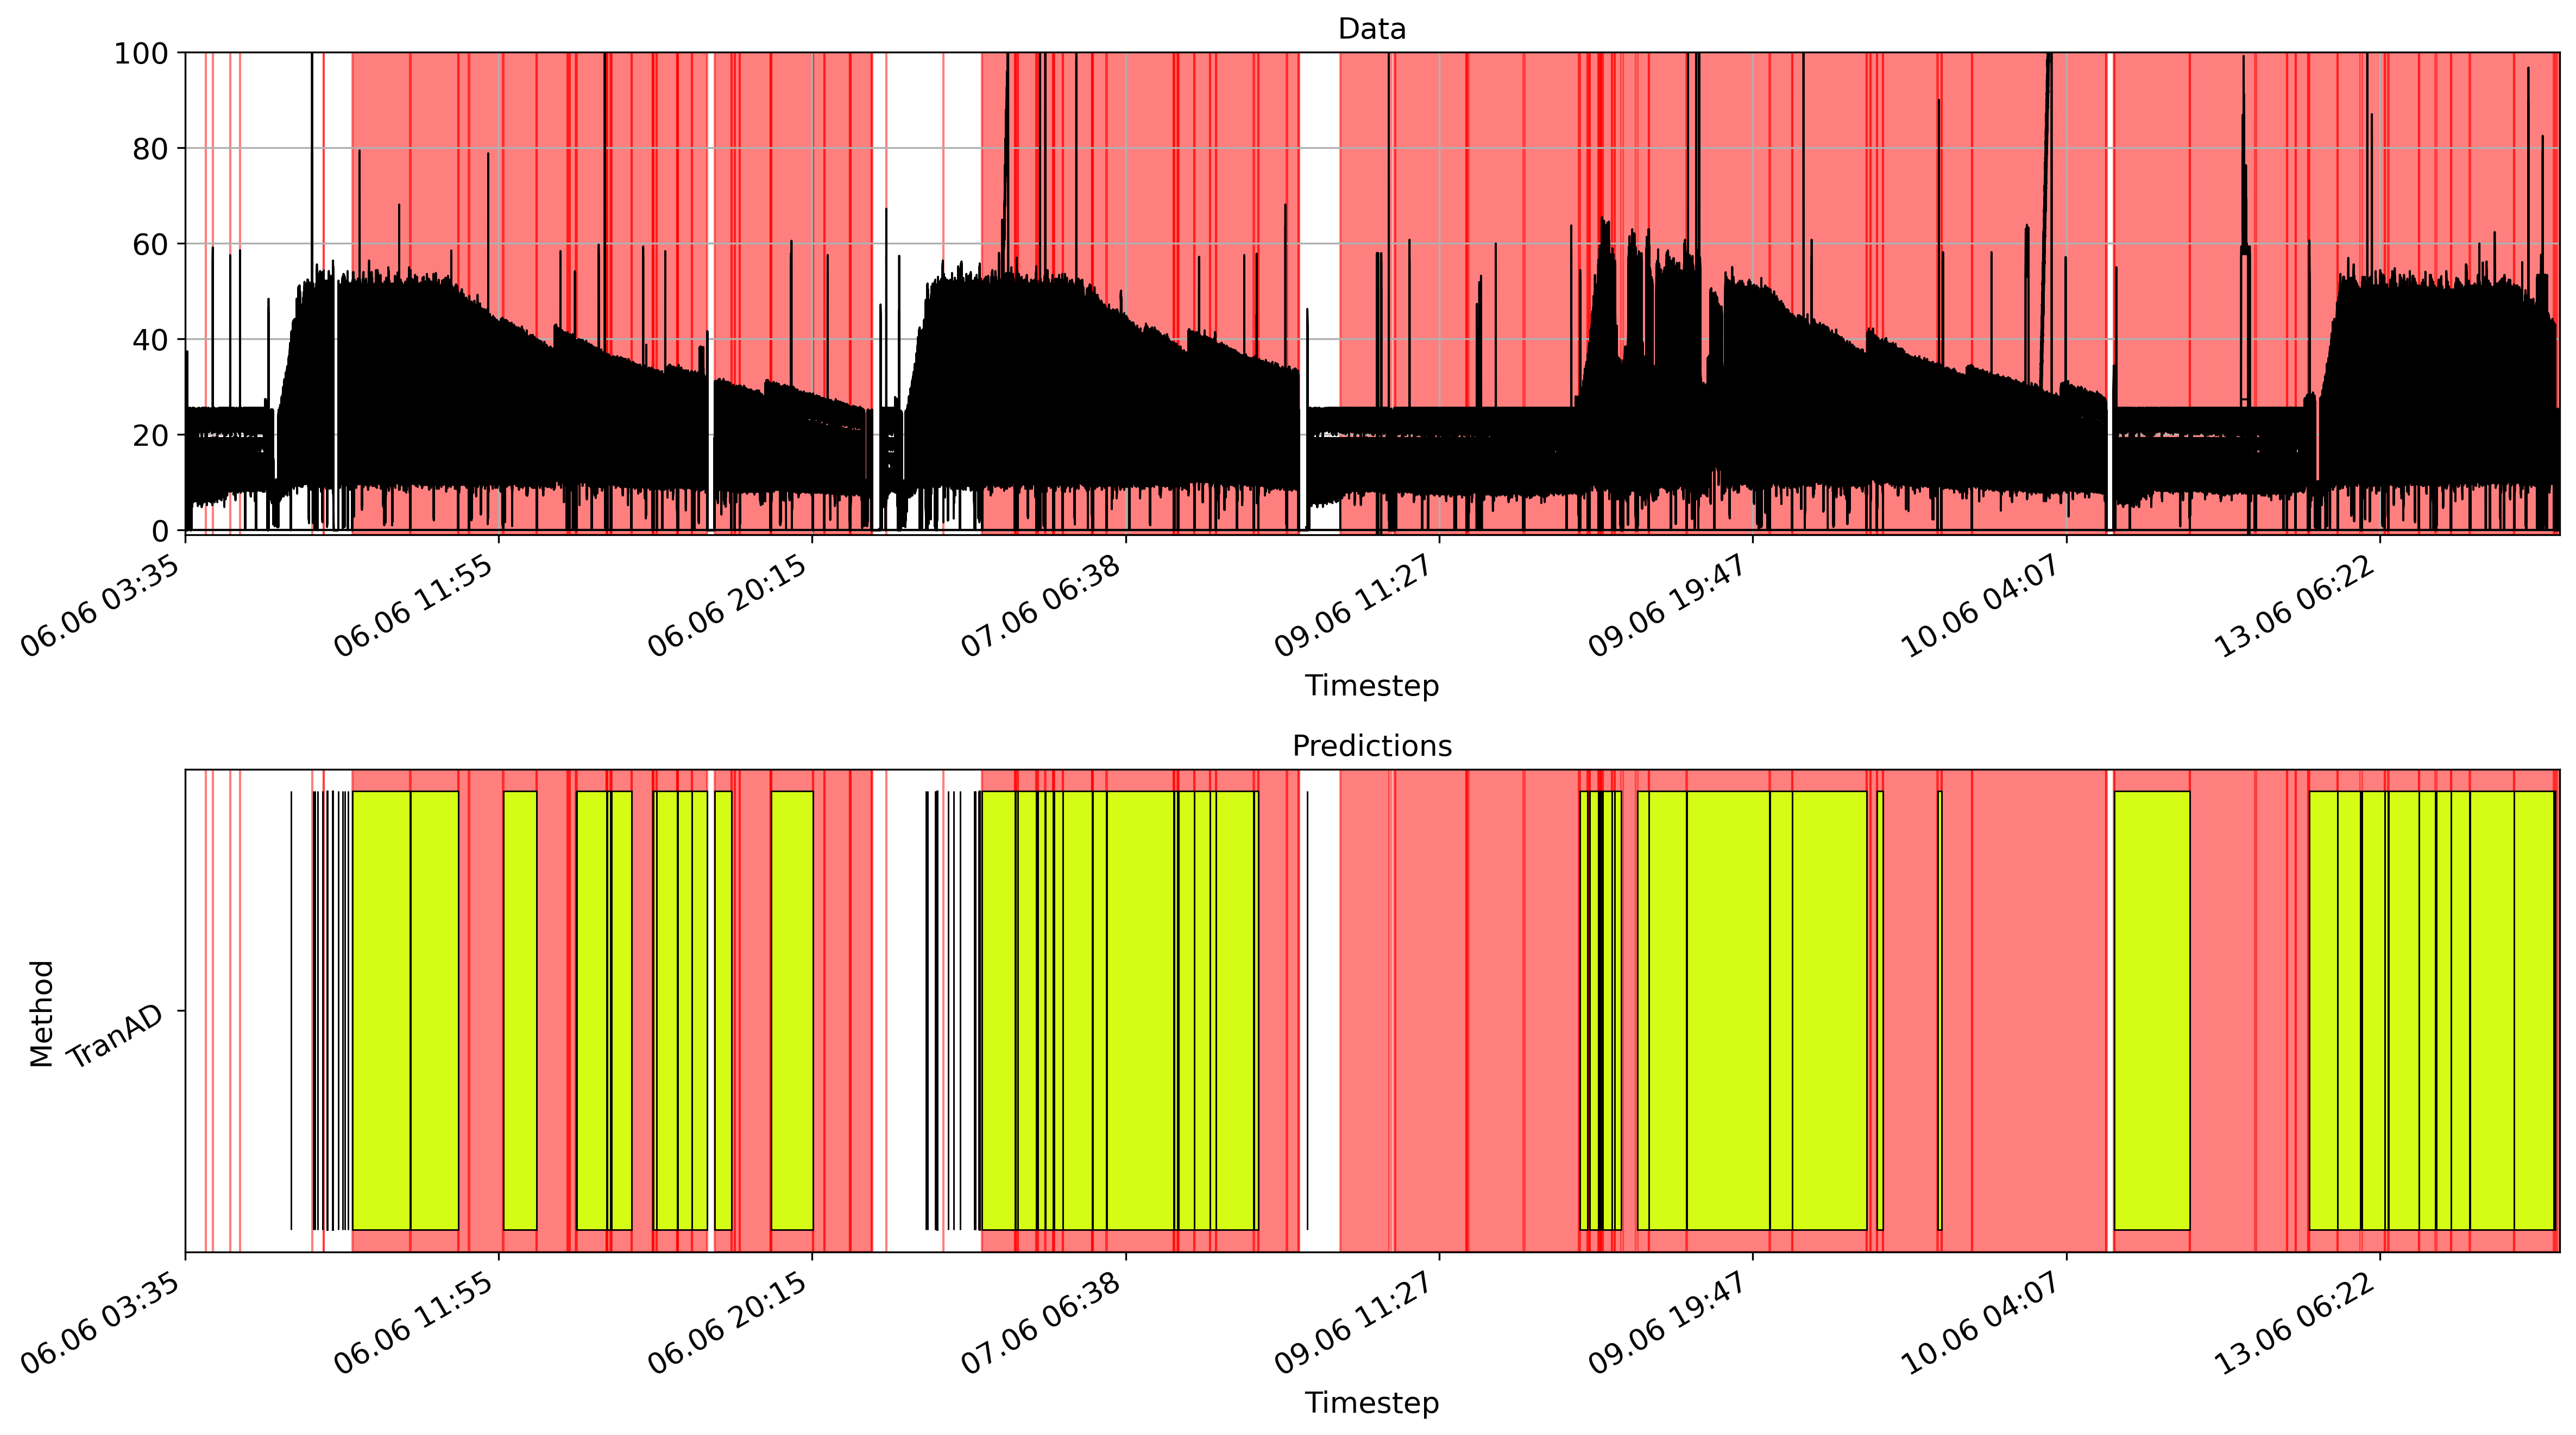

In [32]:
hlt_data_pd = pd.read_hdf('/eos/user/k/kstehle/atlas-hlt-datasets/unreduced_hlt_test_set_2023_x.h5')

hlt_data_pd.fillna(0, inplace=True)

hlt_data_np = hlt_data_pd.to_numpy()

labels_pd = pd.read_hdf('/eos/user/k/kstehle/atlas-hlt-datasets/unreduced_hlt_test_set_2023_y.h5')

labels_np = labels_pd.to_numpy()

timestamps = labels_pd.index


# Convert the index to datetime format
timestamps_datetime = pd.to_datetime(timestamps)

# Apply strftime to format the datetime objects
formatted_timestamps = timestamps_datetime.strftime('%d.%m %H:%M')

labels_np = np.greater_equal(labels_np, 1)

plot_results(hlt_data_np,
                labels_np,
                formatted_timestamps,
                42)

